#Loading raw data

In [1]:
immutable Halo
    x::Float32
    y::Float32
    z::Float32
    vx::Float32
    vy::Float32
    vz::Float32
    mvir::Float32
    m200b::Float32
    m200c::Float32
    m500c::Float32
    m2500c::Float32
    vmax::Float32
    rvmax::Float32
    r200b::Float32
    spin::Float32
    kin_to_pot::Float32
    id::Int64
    pid::Int64
end
m = Float64[]
x = Float64[]
y = Float64[]
z = Float64[]
vx = Float64[]
vy = Float64[]
vz = Float64[]
r = Float64[]
id = Int64[]
pid = Int64[]
halos = Array(Halo, 10000000)
sz = stat("Dark_Sky_1600_Halos/ds.data").size
open("Dark_Sky_1600_Halos/ds.data", "r") do f
    # skip the header and sha1...
    seek(f, 1216 + (20+4)*64)
    
    while position(f) < sz-sizeof(halos)
        # read halos
        read!(f, halos)

        # filter
        ix = find(Float64[h.m200b for h in halos] .> 4.88e11)
        fh = halos[ix]

        append!(m, Float64[h.m200b for h in fh])
        append!(x, Float64[h.x for h in fh])
        append!(y, Float64[h.y for h in fh])
        append!(z, Float64[h.z for h in fh])
        append!(vx, Float64[h.vx for h in fh])
        append!(vy, Float64[h.vy for h in fh])
        append!(vz, Float64[h.vz for h in fh])
        append!(r, Float64[h.r200b for h in fh]);
        append!(id, Int64[h.id for h in fh]);
        append!(pid, Int64[h.pid for h in fh]);
        println(position(f)/sz*100.0)
    end
    
    halos2 = Array(Halo, int((sz-position(f))/sizeof(Halo)))
    # read halos
    read!(f, halos2)

    # filter
    ix = find(Float64[h.m200b for h in halos2] .> 4.88e11)
    fh = halos2[ix]

    append!(m, Float64[h.m200b for h in fh])
    append!(x, Float64[h.x for h in fh])
    append!(y, Float64[h.y for h in fh])
    append!(z, Float64[h.z for h in fh])
    append!(vx, Float64[h.vx for h in fh])
    append!(vy, Float64[h.vy for h in fh])
    append!(vz, Float64[h.vz for h in fh])
    append!(r, Float64[h.r200b for h in fh]);
    append!(id, Int64[h.id for h in fh]);
    append!(pid, Int64[h.pid for h in fh]);
end
halos=nothing
gc()

@show length(x)
@show length(m)
@show length(id)
@show length(pid)
@show minimum(x)
@show minimum(m)
@show maximum(x)
@show maximum(m)

3.647541822747575
7.295071097994443
10.942600373241312
14.590129648488178
18.237658923735047
21.88518819898192
25.532717474228782
29.180246749475653
32.827776024722525
36.47530529996939
40.12283457521626
43.77036385046313
47.417893125709995
51.06542240095686
54.71295167620374
58.3604809514506
62.008010226697465
65.65553950194433
69.3030687771912
72.95059805243808
76.59812732768494
80.24565660293182
83.89318587817868
87.54071515342554
91.18824442867242
94.83577370391927
98.48330297916615
length(x) => 40325638
length(m) => 40325638
length(id) => 40325638
length(pid) => 40325638
minimum(x) => 0.00011353025183780119
minimum(m) => 4.88089124864e11
maximum(x) => 1599.9998779296875
maximum(m) => 4.425567587794944e15


4.425567587794944e15

#Building a world

In [2]:
push!(LOAD_PATH,"./src/")
import nbody
reload("nbody")
nb = nbody;

In [3]:
isparent = Dict{Int64, Bool}()

Dict{Int64,Bool} with 0 entries

In [4]:
for i in 1:length(m)
    isparent[id[i]] = false
end

In [5]:
for i in 1:length(m)
    pidi = pid[i]
    if pidi > 0
        isparent[pidi] = true
    end
end

In [6]:
ix = Int64[]
for i in 1:length(m)
    isparent[id[i]] && continue
    push!(ix, i)
end

In [7]:
length(ix)

36828763

In [8]:
m = m[ix]
x = x[ix]
y = y[ix]
z = z[ix]
vx = vx[ix]
vy = vy[ix]
vz = vz[ix]
id = id[ix]
pid = pid[ix];

In [17]:
Mmin = 4.88e12
particles = nb.Particle[nb.Particle(x[i]*1.e3, y[i]*1.e3, z[i]*1.e3, m[i]) for i in 1:length(x)];

In [18]:
# filtering ny halo mass
ix = m.>Mmin;
particles = nb.Particle[p for p in particles[ix]];
# now scaling mass
@show fac = sum([p._m for p in particles]) / 4.88088986e+09 / 4096 / 4096 / 4096
particles = nb.Particle[nb.Particle(p._x,p._y,p._z,p._m/fac/1.e10) for p in particles];

fac = (((sum($(Expr(:comprehension, :(p._m), :(p = particles)))) / 4.88088986e9) / 4096) / 4096) / 4096 => 0.06963204353873462


In [19]:
length(particles)

2331913

In [20]:
maximum(m)

6.04791256383488e14

In [13]:
w = nb.World(
        particles,
        5000.0,
        0.5,
        0.035,
        nb.Cosmological,
        0.295126,
        0.704874);
for i in 1:w.n
    w.vx[i] = vx[ix[i]]
    w.vy[i] = vy[ix[i]]
    w.vz[i] = vz[ix[i]]
end

In [14]:
# filterin by location
nw = nb.filter_r(w, 100000.0);
nb.save(nw, "w.data")

smth = sqrt(w.smth2) => 5000.0
opening_alpha = sqrt(w.opening_alpha2) => 0.5
dtfrac = w.dtfrac => 0.035
space = typeof(w.space) => Cosmological
Ω0 = w.Ω0 => 0.295126
ΩΛ = w.ΩΛ => 0.704874


In [16]:
nw.n

43916

In [52]:
w = nb.load_w("w.data");

In [46]:
using Winston

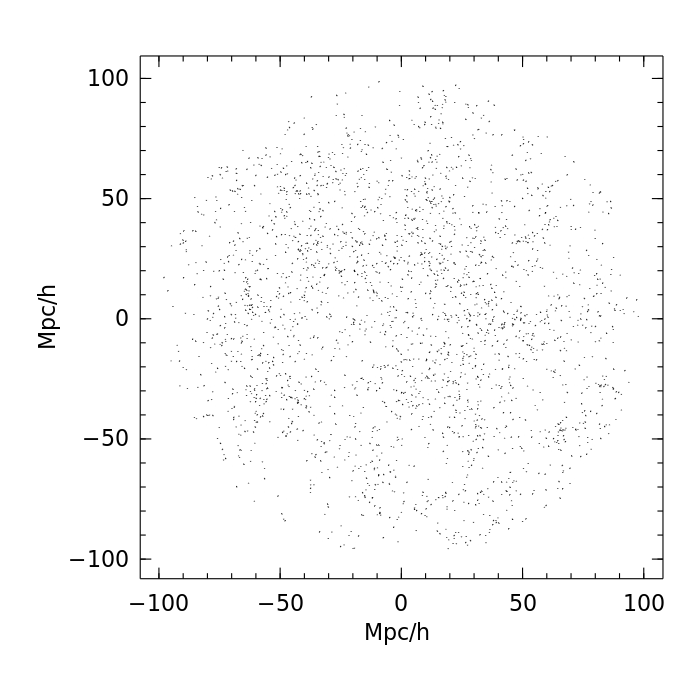

In [47]:
nb.plot(nw)

In [48]:
nb.save(nw, "BYHALO.DATA")

#Optimizing!

In [1]:
using Winston

In [2]:
workers()

1-element Array{Int64,1}:
 1

In [3]:
addprocs(8)

8-element Array{Any,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [4]:
workers()

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [5]:
@everywhere begin
    push!(LOAD_PATH,"./src/")
    import nbody
    reload("nbody")
    nb = nbody;
end

In [6]:
w = nb.load_w("BYHALO.DATA");

In [7]:
#sim = nb.Simulation(deepcopy(w), limit_by_steps=false, stepc=1, ti=0.0196078431372549, tf=1.0, n_test_particle=3*w.n);
sim = nb.Simulation(deepcopy(w), limit_by_steps=false, stepc=1, ti=0.05, tf=1.0, n_test_particle=3*w.n);
sim.w.smth2 = 8500.0^2

7.225e7

In [8]:
opt = nb.Optimization(sim);

In [8]:
opt.sim = nb.load_sim("sim.data");

LoadError: opt not defined
while loading In[8], in expression starting on line 1

In [9]:
(100000^3/5200)^(1/3)

5772.078366321594

 grade=511184.2302072217 n=3963


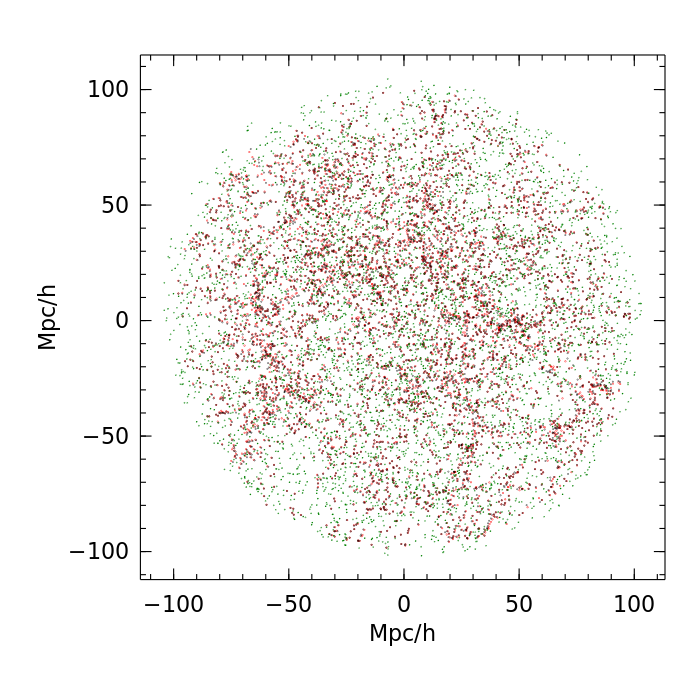

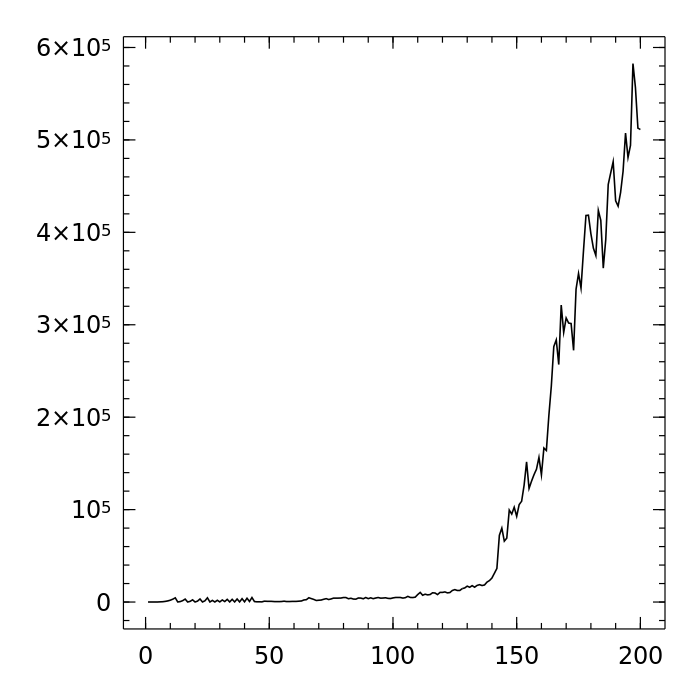

maximum(opt.grad) => 4.316770079081937e7
g=511184.2302072217


In [10]:
step=0
N=500
ga = Float64[]
Winston.set_default_plot_size(700,700)
import IJulia
#for l_target_t in linspace(log(opt.sim.tf*0.99), log(opt.sim.ti), N)
for l_target_t in linspace(log(opt.sim.tf*0.999), log(0.1), 200)    
    step+=1
    target_t = exp(l_target_t)
    
    println("----------------------- ti=",target_t," comp: ",step/N*100)
    opt.sim.ti = target_t
    g=nb.optimize(opt, 5, 5000.0)
    send_ipython(IJulia.publish, msg_pub(IJulia.execute_msg, "clear_output", [:wait => true]))
    #? nb.exec!(sim, false, silent=true)
    display(nb.plot(opt))
    push!(ga, g/1.0)
    display(Winston.plot([1:length(ga)], ga))
    
    #pp = FramedPlot()
    #add(pp, Histogram(hist(opt.grad[opt.grad.>1000])...))    
    #display(pp)
    println("==============================================")
    @show maximum(opt.grad)
    println("g=",g/1.0)
    #if g/1000000.0>1.0
    #    break
    #end
    #break
end

In [12]:
nb.save(opt.sim, "sim.data")

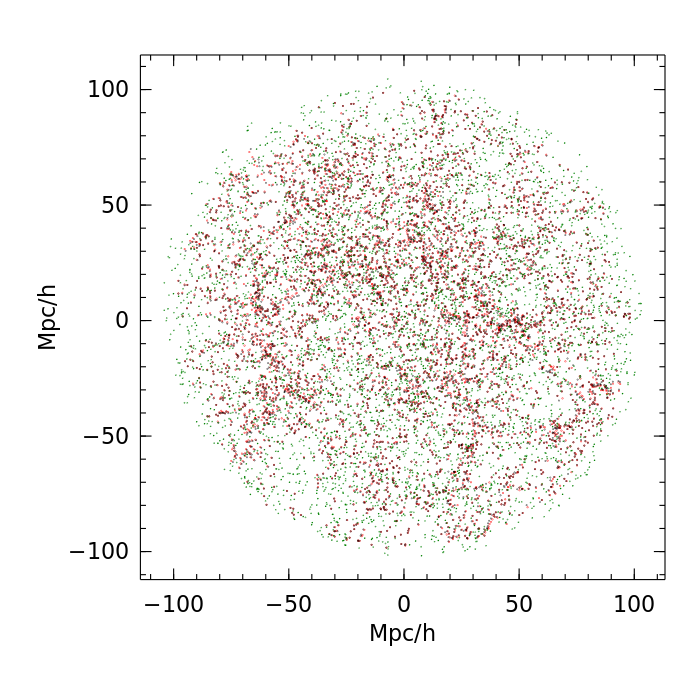

In [13]:
nb.plot(opt)

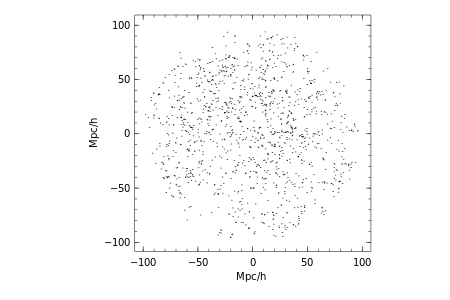

In [37]:
nb.plot(w)

In [2]:
sim = nb.load_sim("sim.data")
w = nb.load_w("w.data");

tn => 15534


In [3]:
@show w.n
@show sim.w.n

w.n => 5170
sim.w.n => 5178


5178

In [1]:
using Winston
@everywhere begin
    push!(LOAD_PATH,"./src/")
    import nbody
    reload("nbody")
    nb = nbody;
end



In [375]:
sim = nb.load_sim("out11.sim")
w = nb.load_w("BYHALO.DATA")
@show sim.w.n
@show sim.ti
@show w.n
@show w.vx[1]

tn => 15534
sim.w.n => 5178
sim.ti => 0.24721848360553014
w.n => 5178
w.vx[1] => 486.2285770918221


486.2285770918221

In [376]:
function getv(w::nb.World, nw::nb.World)
    vx = zeros(w.n)
    for n in 1:w.n
        mass::Float64 = 0.0
        v::Float64 = 0.0
        pn = nw.particles[n]
        r2 = pn._x^2+pn._y^2+pn._z^2
        r2 > 170000*170000 && continue
        for i in 1:w.n
            pi = w.particles[i]

            dx = pi._x - pn._x
            dy = pi._y - pn._y
            dz = pi._z - pn._z
            d2 = dx*dx+dy*dy+dz*dz

            if d2 < 8000.0*8000.0#ns.w.smth2
                mass += pi._m
                v += w.vx[i]*pi._m
            end

        end
        vx[n] = v/mass
        n % 1000 == 0 && @show n/w.n*100
    end
    vx
end
vx = getv(w, sim.w)
nvx = getv(sim.w, sim.w);

(n / w.n) * 100 => 19.312475859405176
(n / w.n) * 100 => 38.62495171881035
(n / w.n) * 100 => 57.93742757821553
(n / w.n) * 100 => 77.2499034376207
(n / w.n) * 100 => 96.56237929702588
(n / w.n) * 100 => 19.312475859405176
(n / w.n) * 100 => 38.62495171881035
(n / w.n) * 100 => 57.93742757821553
(n / w.n) * 100 => 77.2499034376207
(n / w.n) * 100 => 96.56237929702588


In [377]:
length(vx)

5178

In [378]:
length(nvx)

5178

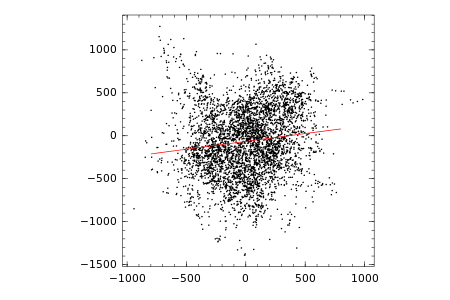

In [380]:
hold(false)
scatter(vx, nvx, 0.01, aspect_ratio=1.0)
hold(true)
b,a = linreg(vx, nvx)
x = [-800,800]
y = b.+a.*x
plot(x,y,"red")


In [381]:
nvx[1:5]./vx[1:5]

5-element Array{Float64,1}:
 -0.368575
 -0.355137
 -1.82664 
  1.1196  
  0.874583

In [382]:
linreg(vx, nvx)

2-element Array{Float64,1}:
 -65.9905  
   0.182213

In [384]:
1/0.24-1

3.166666666666667

In [164]:
sum(isnan(vx))

0

In [165]:
nb.exec!(sim, false)

s=1 t=0.2805811664387671 dt=0.03467401650356304 /0.094209299s
s=2 t=0.3152551829423302 dt=0.039100798618964906 /0.09184058s
s=3 t=0.35435598156129505 dt=0.04378251421647199 /0.120945205s
s=4 t=0.398138495777767 dt=0.04879781164225057 /0.093148618s
s=5 t=0.4469363074200176 dt=0.05 /0.091551666s
s=6 t=0.49693630742001765 dt=0.05 /0.093454239s
s=7 t=0.5469363074200176 dt=0.05 /0.091211454s
s=8 t=0.5969363074200177 dt=0.05 /0.092486556s
s=9 t=0.6469363074200177 dt=0.05 /0.09048587s
s=10 t=0.6969363074200178 dt=0.05 /0.094417595s
s=11 t=0.7469363074200178 dt=0.05 /0.094040378s
s=12 t=0.7969363074200179 dt=0.05 /0.095167542s
s=13 t=0.8469363074200179 dt=0.05 /0.097170153s
s=14 t=0.896936307420018 dt=0.05 /0.096684449s
s=15 t=0.946936307420018 dt=0.05 /0.092742691s
s=16 t=0.996936307420018 dt=0.003063692579981958 /0.122092516s

--- Done!

elapsed time: 1.657666636 seconds


In [168]:
sim.w.particles[17]._m

9539.841672863873

In [169]:
w.particles[17]._m

9539.841672863873

In [170]:
minimum([p._m for p in w.particles])

1784.4822081677871

In [171]:
ans/3

594.8274027225957

In [172]:
9539.84/ans

16.037996831240488

In [173]:
sum([p._m for p in w.particles])/minimum([p._m for p in w.particles])

25393.274238280406

In [174]:
m = [p._m for p in w.particles];

In [176]:
maximum(m./minimum(m))

229.53599638049528

In [177]:
maximum(m)

409602.9016750594

In [178]:
ans/minimum(m)

229.53599638049528

In [180]:
unique(sort(m))

3053-element Array{Any,1}:
   1784.48
   1786.27
   1788.05
   1789.84
   1791.62
   1793.4 
   1795.19
   1796.97
   1798.76
   1800.54
   1802.33
   1804.11
   1805.9 
      ⋮   
 167743.0 
 168921.0 
 183477.0 
 196495.0 
 207209.0 
 228672.0 
 244888.0 
 274521.0 
 288460.0 
 330215.0 
 409178.0 
 409603.0 